# US cases by state

```
Author name: Daniel Alvarez
Author email: daniel.alvarez@ischool.berkeley.com
```

## Brief description

An ongoing repository of data on coronavirus cases and deaths in the U.S. from the New York Times

https://github.com/nytimes/covid-19-data

## Libraries and initial set-up

In [1]:
## Import packages.

# General tools & operations libraries
import re
import ast
import time
import csv
import itertools
import math
import random
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta, date
from functools import reduce #for merge operations

# Plotting and visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set display of images in the notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%matplotlib notebook


# Import joblib
import joblib

In [2]:
# Set random seed for this project
random_seed = 224
random.seed(random_seed)

## Data ingestion

An ongoing repository of data on coronavirus cases and deaths in the U.S 

<https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html>

In [3]:
d = pd.read_csv("./covid-19-data/us-states.csv", sep=',', delimiter=None)

In [4]:
# Convert columns to str without spaces in lower case
d.columns = d.columns.str.replace('\s+', '_').str.lower()

In [5]:
d.columns

Index(['date', 'state', 'fips', 'cases', 'deaths'], dtype='object')

## Data integrity

### Inspect the data

In [6]:
# Show number of rows and columns of each dataset
print(d.shape)

(8319, 5)


**Comment:** Do not find any null values in the data. 

In [7]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8319 entries, 0 to 8318
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    8319 non-null   object
 1   state   8319 non-null   object
 2   fips    8319 non-null   int64 
 3   cases   8319 non-null   int64 
 4   deaths  8319 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 325.1+ KB


In [8]:
d.head(3)

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0


In [9]:
d.tail(3)

,date,state,fips,cases,deaths
8316,2020-07-31,West Virginia,54,6642,116
8317,2020-07-31,Wisconsin,55,57020,943
8318,2020-07-31,Wyoming,56,2726,26


Inspect number of states

In [10]:
# count number of  rows
len(np.unique(d['state']))

55

In [11]:
np.unique(d['state'])

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

Examine New York

In [12]:
d[d['state']=='New York']

,date,state,fips,cases,deaths
246,2020-03-01,New York,36,1,0
261,2020-03-02,New York,36,1,0
276,2020-03-03,New York,36,2,0
293,2020-03-04,New York,36,11,0
313,2020-03-05,New York,36,22,0
...,...,...,...,...,...
8077,2020-07-27,New York,36,417056,32322
8132,2020-07-28,New York,36,417591,32333
8187,2020-07-29,New York,36,418302,32342
8242,2020-07-30,New York,36,419081,32362


### Track duplicates

**Comment:** I find no duplicate rows across the data sets.

In [13]:
def dup_allrows(data):
    ''' This function generates the number of duplicative rows in the dataset'''
    data_dedup = data.drop_duplicates(keep='first')
    print(data_dedup.shape)
    print(len(data) - len(data_dedup))

In [14]:
dup_allrows(data=d)

(8319, 5)
0


**Comment:** There are no duplicates found.

In [15]:
variable = pd.Series(np.nan)

def dup_byvar(data):
    ''' Output the number of duplicates and percentage of duplicates for each variable in the dataset'''
    for var in data:
        variable = data[var]
    
        # construct variable dataframe less duplicates
        variable_dedup = variable.drop_duplicates(keep='first')

        # print the number of duplicates
        duplicates = len(variable) - len(variable_dedup)
        print(var)
        print('Number of duplicates: ', duplicates)

        # print the percentage of duplicates
        percentage = duplicates/len(data)
        print('Percentage of duplicates: ', percentage)

In [16]:
dup_byvar(data=d)

date
Number of duplicates:  8126
Percentage of duplicates:  0.9768000961654045
state
Number of duplicates:  8264
Percentage of duplicates:  0.9933886284409184
fips
Number of duplicates:  8264
Percentage of duplicates:  0.9933886284409184
cases
Number of duplicates:  2076
Percentage of duplicates:  0.24954922466642626
deaths
Number of duplicates:  5688
Percentage of duplicates:  0.6837360259646592


## Data engineering

Transform the accrual date to a date variable

In [17]:
#Extract the year, month and day from the accrual_date variable and create data variable
def datecreate(data):
    ''' Create variable from the accrual date variable'''
    data['year'] = data['date'].str[:4]
    data['month'] = data['date'].str[5:7]
    data['day'] = data['date'].str[8:]
    data['date_dt'] = pd.to_datetime(data['year']+data['month']+data['day'], format='%Y%m%d')
    data.drop(columns=['year','month','day'])

In [18]:
datecreate(data=d)

#drop unnecessary columns for analysis
d = d.drop(columns=['year','month','day'])

In [19]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8319 entries, 0 to 8318
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     8319 non-null   object        
 1   state    8319 non-null   object        
 2   fips     8319 non-null   int64         
 3   cases    8319 non-null   int64         
 4   deaths   8319 non-null   int64         
 5   date_dt  8319 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 390.1+ KB


Check first and last dates in the time series and top date by count

In [20]:
def dates(data):
    print("First date of appearance:", min(data['date_dt']))
    print("Last date of appearance:", max(data['date_dt']))
    print("Top dates by count")
    print(data.date_dt.value_counts().sort_values(ascending=False).head())

In [21]:
dates(data=d)

First date of appearance: 2020-01-21 00:00:00
Last date of appearance: 2020-07-31 00:00:00
Top dates by count
2020-07-22    55
2020-07-11    55
2020-04-01    55
2020-07-09    55
2020-03-30    55
Name: date_dt, dtype: int64


In [22]:
d.head()

,date,state,fips,cases,deaths,date_dt
0,2020-01-21,Washington,53,1,0,2020-01-21
1,2020-01-22,Washington,53,1,0,2020-01-22
2,2020-01-23,Washington,53,1,0,2020-01-23
3,2020-01-24,Illinois,17,1,0,2020-01-24
4,2020-01-24,Washington,53,1,0,2020-01-24


#### Top death count states

In [23]:
agg_dict = {'deaths':[np.max],'cases':[np.max]}
d_aggbydeaths = d.groupby(['state']).agg(agg_dict).reset_index()

In [24]:
# rename columns
d_aggbydeaths.columns = ['state','total_deaths', 'total_cases']

# create a death rate variable
d_aggbydeaths['death_rate'] = d_aggbydeaths['total_deaths']/d_aggbydeaths['total_cases']

In [25]:
d_aggbydeaths = d_aggbydeaths.sort_values(['total_deaths'], ascending=False)

top10 = d_aggbydeaths.head(10)
top10

,state,total_deaths,total_cases,death_rate
33,New York,32372,419723,0.077127
31,New Jersey,15825,183535,0.086223
4,California,9222,502273,0.018361
22,Massachusetts,8609,117612,0.073198
14,Illinois,7703,180701,0.042628
46,Texas,7265,441688,0.016448
40,Pennsylvania,7261,116787,0.062173
9,Florida,6842,470378,0.014546
23,Michigan,6453,90752,0.071106
6,Connecticut,4432,49810,0.088978


In [26]:
top15 = d_aggbydeaths.head(15)
top15

,state,total_deaths,total_cases,death_rate
33,New York,32372,419723,0.077127
31,New Jersey,15825,183535,0.086223
4,California,9222,502273,0.018361
22,Massachusetts,8609,117612,0.073198
14,Illinois,7703,180701,0.042628
46,Texas,7265,441688,0.016448
40,Pennsylvania,7261,116787,0.062173
9,Florida,6842,470378,0.014546
23,Michigan,6453,90752,0.071106
6,Connecticut,4432,49810,0.088978


In [27]:
d_aggbydeaths.head(30)

,state,total_deaths,total_cases,death_rate
33,New York,32372,419723,0.077127
31,New Jersey,15825,183535,0.086223
4,California,9222,502273,0.018361
22,Massachusetts,8609,117612,0.073198
14,Illinois,7703,180701,0.042628
46,Texas,7265,441688,0.016448
40,Pennsylvania,7261,116787,0.062173
9,Florida,6842,470378,0.014546
23,Michigan,6453,90752,0.071106
6,Connecticut,4432,49810,0.088978


In [28]:
d_aggbydeathrates = d_aggbydeaths.sort_values(['death_rate'], ascending=False)

In [29]:
d_aggbydeathrates.head(20)

,state,total_deaths,total_cases,death_rate
6,Connecticut,4432,49810,0.088978
31,New Jersey,15825,183535,0.086223
33,New York,32372,419723,0.077127
22,Massachusetts,8609,117612,0.073198
23,Michigan,6453,90752,0.071106
30,New Hampshire,415,6583,0.063041
40,Pennsylvania,7261,116787,0.062173
42,Rhode Island,1007,19022,0.052939
8,District of Columbia,585,12126,0.048243
36,Northern Mariana Islands,2,42,0.047619


In [30]:
d_aggbycases = d_aggbydeaths.sort_values(['total_cases'], ascending=False)

In [31]:
top10_bycases = d_aggbycases.head(10)
top10_bycases

,state,total_deaths,total_cases,death_rate
4,California,9222,502273,0.018361
9,Florida,6842,470378,0.014546
46,Texas,7265,441688,0.016448
33,New York,32372,419723,0.077127
31,New Jersey,15825,183535,0.086223
14,Illinois,7703,180701,0.042628
2,Arizona,3695,174108,0.021222
10,Georgia,3674,171342,0.021442
34,North Carolina,1947,122433,0.015903
22,Massachusetts,8609,117612,0.073198


In [32]:
np.unique(top10['state'])

array(['California', 'Connecticut', 'Florida', 'Illinois',
       'Massachusetts', 'Michigan', 'New Jersey', 'New York',
       'Pennsylvania', 'Texas'], dtype=object)

Pull the time series for the top 10 states by death counts

In [33]:
d_top10 = pd.merge(d, top10, how='inner', on=['state'])
d_top10['death_rate'] = d_top10['deaths']/d_top10['cases']

Pull the time series for the top 10 states by cases

In [34]:
d_top10_bycases = pd.merge(d, top10_bycases, how='inner', on=['state'])
d_top10_bycases['death_rate'] = d_top10_bycases['deaths']/d_top10['cases']

Transpose dataset to have death_rate for each top 10 state over time

In [35]:
d_top10_dr = d_top10[['date_dt','state','death_rate']]

In [36]:
d_top10_dr = d_top10_dr.pivot(index='date_dt', columns='state', values='death_rate')
d_top10_dr

state,California,Connecticut,Florida,Illinois,Massachusetts,Michigan,New Jersey,New York,Pennsylvania,Texas
date_dt,,,,,,,,,,
2020-01-24,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-07-27,0.018291,0.090195,0.013703,0.043676,0.073633,0.073366,0.086963,0.077500,0.063490,0.015640
2020-07-28,0.018351,0.090124,0.013838,0.043539,0.073600,0.073002,0.086848,0.077427,0.063060,0.015785
2020-07-29,0.018260,0.089322,0.014027,0.043291,0.073532,0.072181,0.086576,0.077317,0.062783,0.016194


Transpose dataset to have deaths for each top 10 county over time

In [37]:
d_top10_deaths = d_top10[['date_dt','state','deaths']]
d_top10_deaths = d_top10_deaths.pivot(index='date_dt', columns='state', values='deaths')

Transpose dataset to have cases for each top 10 county over time

In [38]:
d_top10_cases = d_top10_bycases[['date_dt','state','cases']]
d_top10_cases = d_top10_cases.pivot(index='date_dt', columns='state', values='cases')
d_top10_cases

state,Arizona,California,Florida,Georgia,Illinois,Massachusetts,New Jersey,New York,North Carolina,Texas
date_dt,,,,,,,,,,
2020-01-24,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2020-01-25,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2020-01-26,1.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2020-01-27,1.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2020-01-28,1.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-07-27,163918.0,467103.0,432739.0,155907.0,174442.0,115926.0,181732.0,417056.0,114689.0,402295.0
2020-07-28,165994.0,474951.0,441969.0,160038.0,175588.0,116182.0,182215.0,417591.0,116376.0,412744.0
2020-07-29,168361.0,487855.0,451415.0,163547.0,176967.0,116684.0,182475.0,418302.0,118100.0,421817.0


In [39]:
d_top10_dr.index[-30:]

DatetimeIndex(['2020-07-02', '2020-07-03', '2020-07-04', '2020-07-05',
               '2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09',
               '2020-07-10', '2020-07-11', '2020-07-12', '2020-07-13',
               '2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17',
               '2020-07-18', '2020-07-19', '2020-07-20', '2020-07-21',
               '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25',
               '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29',
               '2020-07-30', '2020-07-31'],
              dtype='datetime64[ns]', name='date_dt', freq=None)

In [40]:
d_top10_deaths.index[-30:]

DatetimeIndex(['2020-07-02', '2020-07-03', '2020-07-04', '2020-07-05',
               '2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09',
               '2020-07-10', '2020-07-11', '2020-07-12', '2020-07-13',
               '2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17',
               '2020-07-18', '2020-07-19', '2020-07-20', '2020-07-21',
               '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25',
               '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29',
               '2020-07-30', '2020-07-31'],
              dtype='datetime64[ns]', name='date_dt', freq=None)

In [41]:
d_top10_dr.columns

Index(['California', 'Connecticut', 'Florida', 'Illinois', 'Massachusetts',
       'Michigan', 'New Jersey', 'New York', 'Pennsylvania', 'Texas'],
      dtype='object', name='state')

#### Plot deaths and death rates in top death count states

<IPython.core.display.Javascript object>


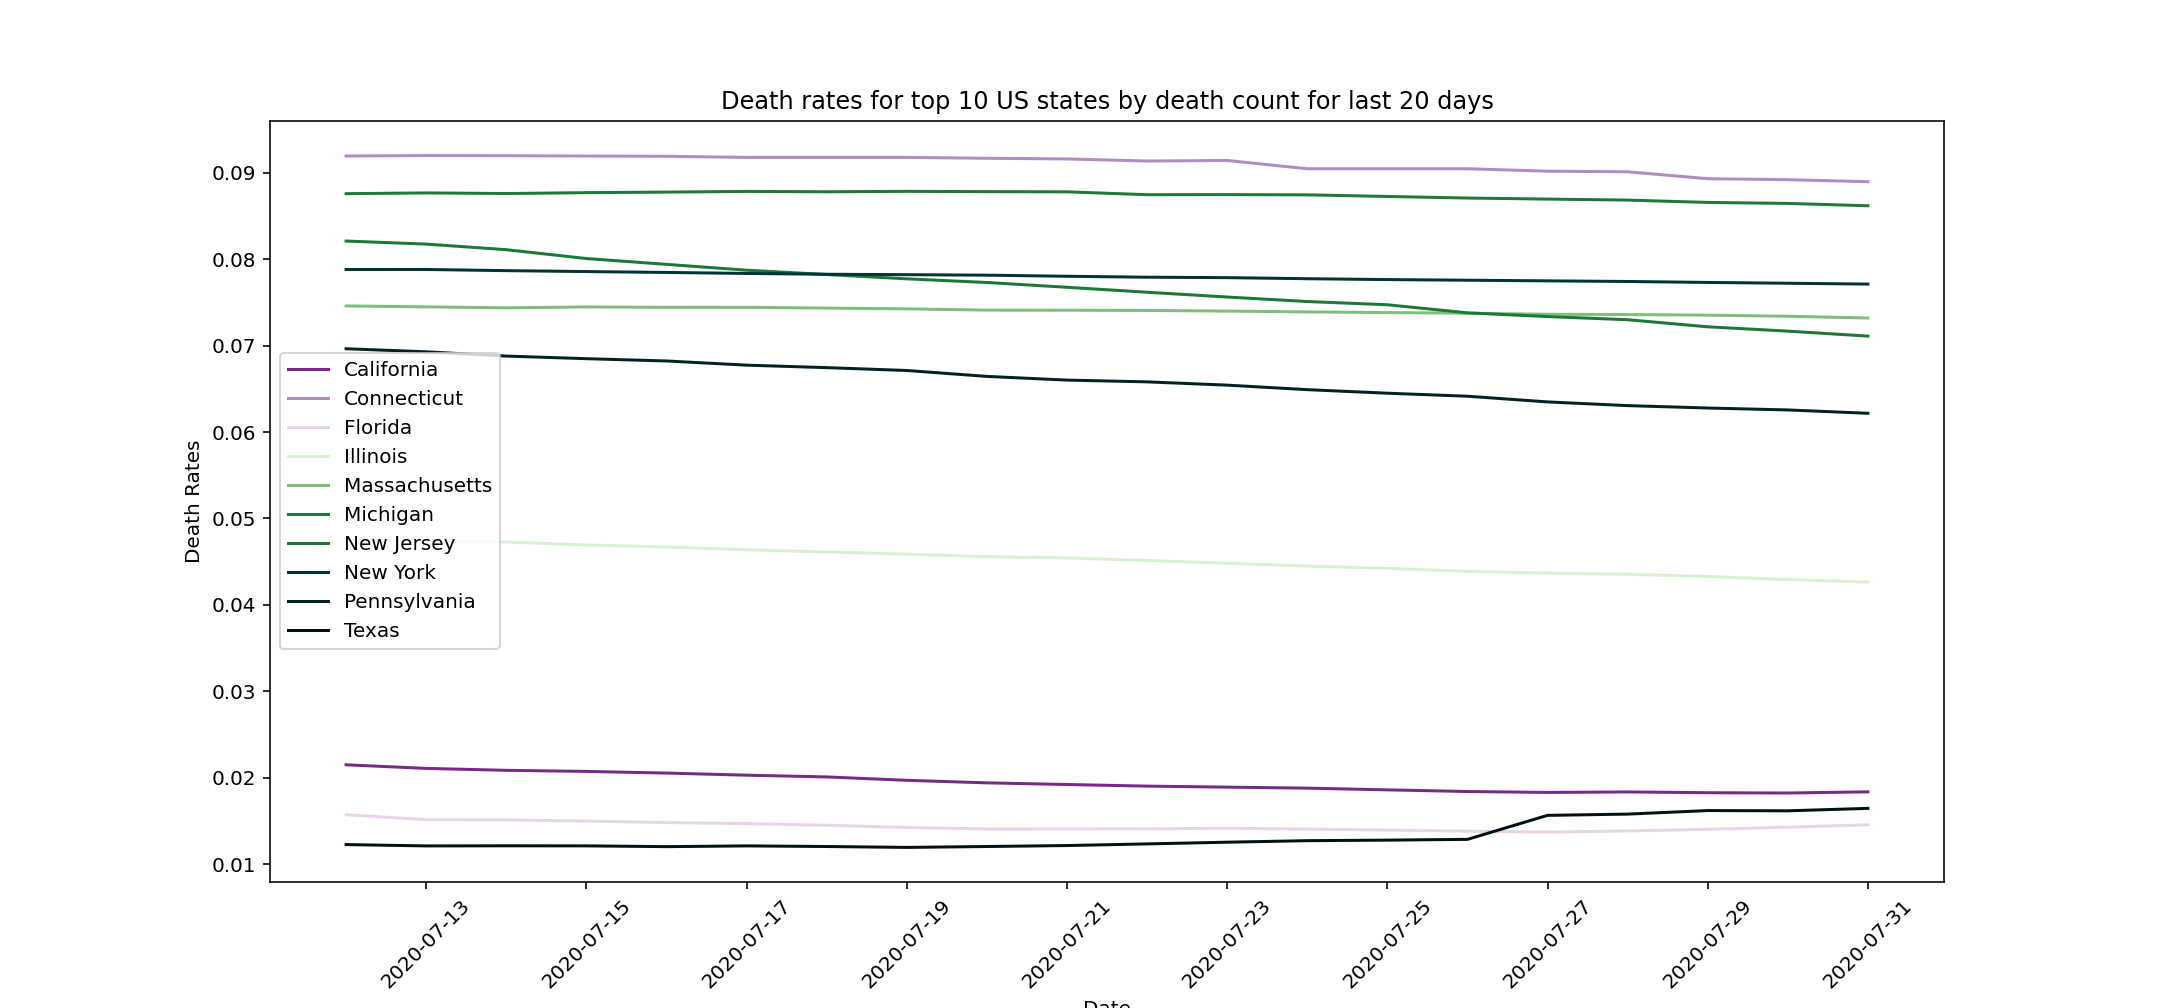

In [42]:
## Plot death rate for top 10 counties

palette_7 = ['#762a83','#af8dc3','#e7d4e8','#d9f0d3','#7fbf7b','#1b7837', '#1f7838', '#003333', '#002222', '#001111']
# Create y as values and x as the index
y0 = d_top10_dr[d_top10_dr.columns[0]][-20:]
y1 = d_top10_dr[d_top10_dr.columns[1]][-20:]
y2 = d_top10_dr[d_top10_dr.columns[2]][-20:]
y3 = d_top10_dr[d_top10_dr.columns[3]][-20:]
y4 = d_top10_dr[d_top10_dr.columns[4]][-20:]
y5 = d_top10_dr[d_top10_dr.columns[5]][-20:]
y6 = d_top10_dr[d_top10_dr.columns[6]][-20:]
y7 = d_top10_dr[d_top10_dr.columns[7]][-20:]
y8 = d_top10_dr[d_top10_dr.columns[8]][-20:]
y9 = d_top10_dr[d_top10_dr.columns[9]][-20:]

x = d_top10_dr.index[-20:]

# Set figure size.
fig, ax = plt.subplots(figsize=(15,7))

# Create plot.
ax.plot(x, y0, color=palette_7[0])
ax.plot(x, y1, color=palette_7[1])
ax.plot(x, y2, color=palette_7[2])
ax.plot(x, y3, color=palette_7[3])
ax.plot(x, y4, color=palette_7[4])
ax.plot(x, y5, color=palette_7[5])
ax.plot(x, y6, color=palette_7[6])
ax.plot(x, y7, color=palette_7[7])
ax.plot(x, y8, color=palette_7[8])
ax.plot(x, y9, color=palette_7[9])

# set ticklabels
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 1 == 0:  # every 10th label is kept
        label.set_visible(True)
        label.set_rotation(45)
    else:
        label.set_visible(False)


# omit Unknown county
# ax.legend([d_top10_dr.columns[0], d_top10_dr.columns[1], d_top10_dr.columns[2], d_top10_dr.columns[3], d_top10_dr.columns[4],
#          d_top10_dr.columns[5], d_top10_dr.columns[6], d_top10_dr.columns[7], d_top10_dr.columns[8], d_top10_dr.columns[9]])

ax.legend([d_top10_dr.columns[0], d_top10_dr.columns[1], d_top10_dr.columns[2], d_top10_dr.columns[3], d_top10_dr.columns[4],
          d_top10_dr.columns[5], d_top10_dr.columns[6], d_top10_dr.columns[7], d_top10_dr.columns[8], d_top10_dr.columns[9]])

#Set title.
ax.set(title="Death rates for top 10 US states by death count for last 20 days", xlabel="Date", ylabel="Death Rates")

# show plot.
plt.show()

In [43]:
## Plot death rate for top 10 counties

palette_7 = ['#762a83','#af8dc3','#e7d4e8','#d9f0d3','#7fbf7b','#1b7837', '#1f7838', '#003333', '#002222', '#001111']

def plotdeaths(data, title, ylabel):
    ''' Plot deaths and death rates for the top 10 US counties'''
    # Create y as values and x as the index
    y0 = data[data.columns[0]][-30:]
    y1 = data[data.columns[1]][-30:]
    y2 = data[data.columns[2]][-30:]
    y3 = data[data.columns[3]][-30:]
    y4 = data[data.columns[4]][-30:]
    y5 = data[data.columns[5]][-30:]
    y6 = data[data.columns[6]][-30:]
    y7 = data[data.columns[7]][-30:]
    y8 = data[data.columns[8]][-30:]
    y9 = data[data.columns[9]][-30:]

    x = data.index[-30:]

    # Set figure size.
    fig, ax = plt.subplots(figsize=(15,7))

    # Create plot.
    ax.plot(x, y0, color=palette_7[0])
    ax.plot(x, y1, color=palette_7[1])
    ax.plot(x, y2, color=palette_7[2])
    ax.plot(x, y3, color=palette_7[3])
    ax.plot(x, y4, color=palette_7[4])
    ax.plot(x, y5, color=palette_7[5])
    ax.plot(x, y6, color=palette_7[6])
    ax.plot(x, y7, color=palette_7[7])
    ax.plot(x, y8, color=palette_7[8])
    ax.plot(x, y9, color=palette_7[9])

    # set ticklabels
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 1 == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(45)
        else:
            label.set_visible(False)

    # Set legend
    #ax.legend([data.columns[0], data.columns[1], data.columns[2], data.columns[3], data.columns[4],
    #          data.columns[5], data.columns[6], data.columns[7], data.columns[8], data.columns[9]])

    ax.legend([data.columns[0], data.columns[1], data.columns[2], data.columns[3], data.columns[4],
              data.columns[5], data.columns[6], data.columns[7], data.columns[8], data.columns[9]])

    
    #Set title.
    ax.set(title=title, xlabel="Date", ylabel=ylabel)

    # show plot.
    plt.show()

<IPython.core.display.Javascript object>


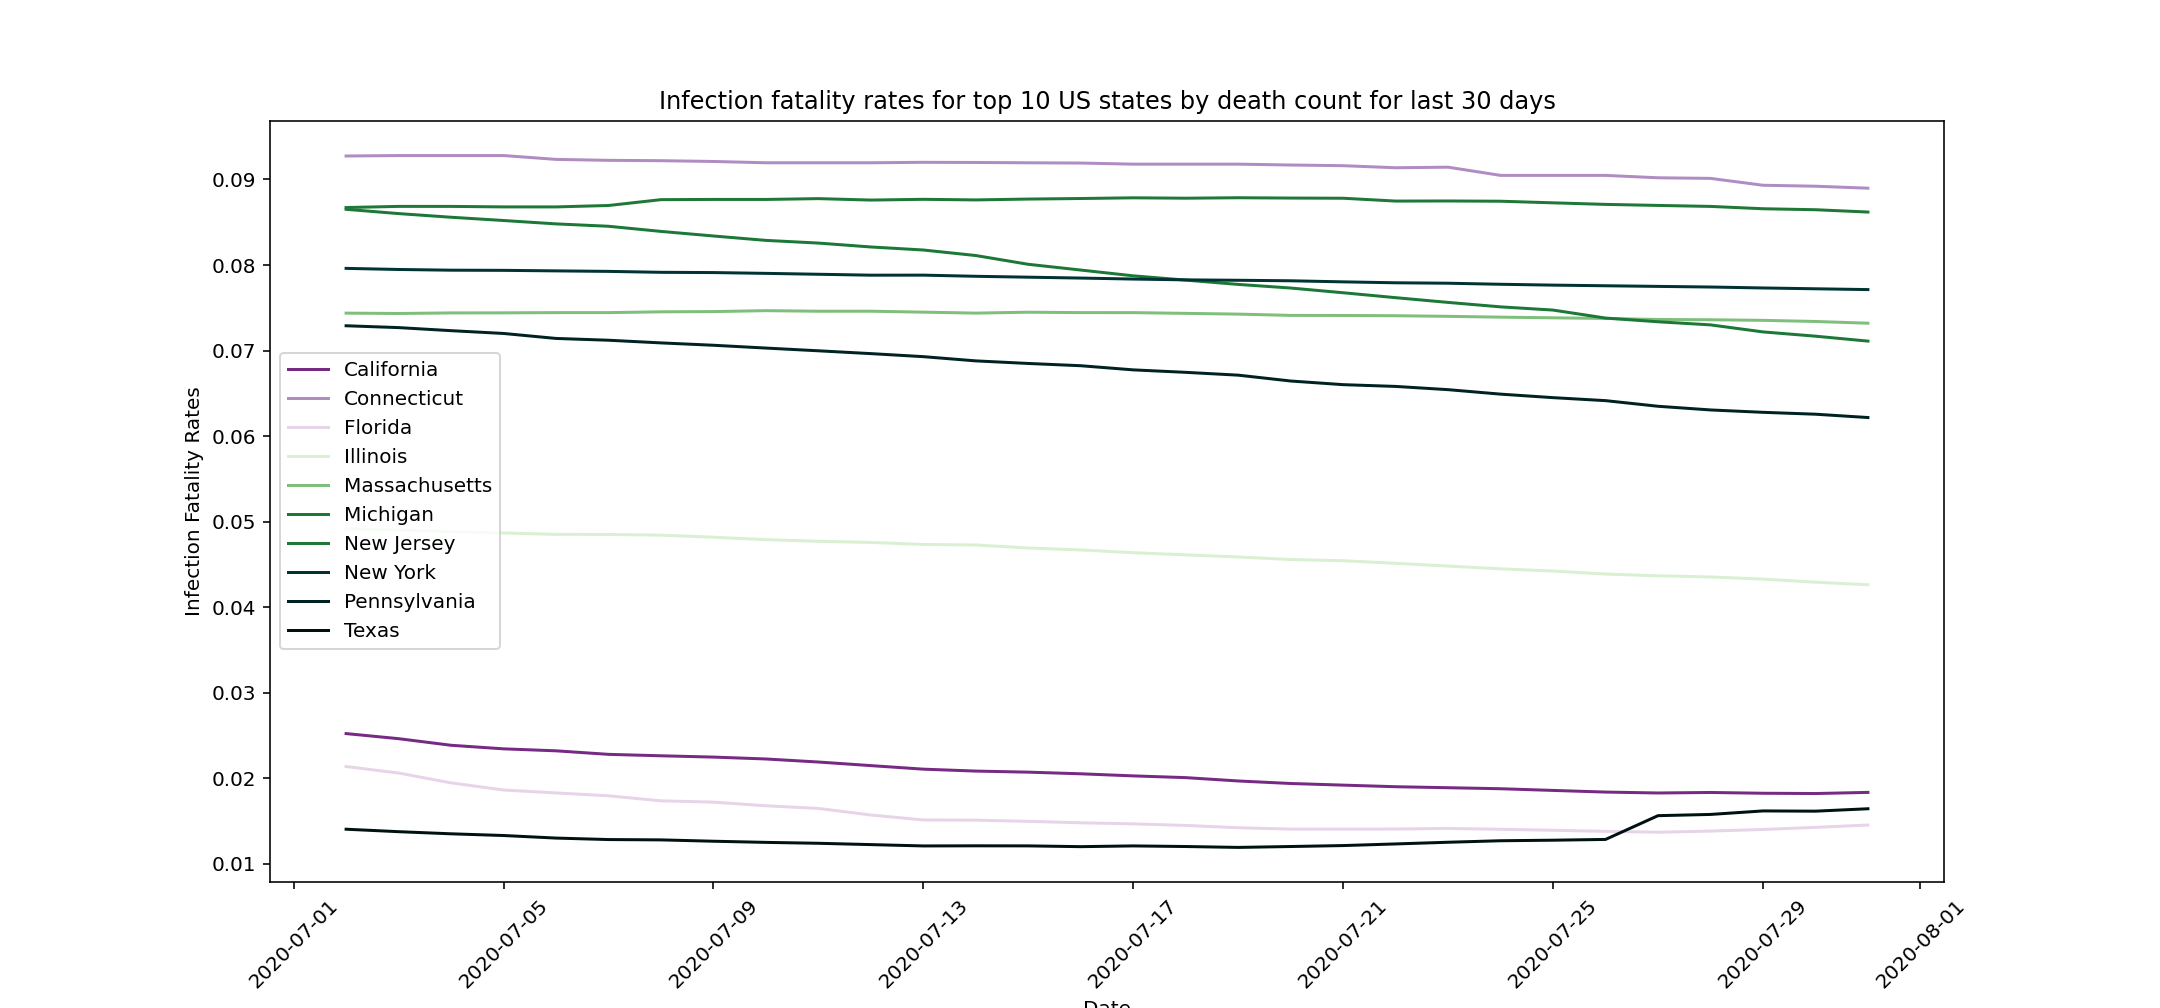

In [44]:
plotdeaths(data=d_top10_dr, title="Infection fatality rates for top 10 US states by death count for last 30 days", ylabel="Infection Fatality Rates")

<IPython.core.display.Javascript object>


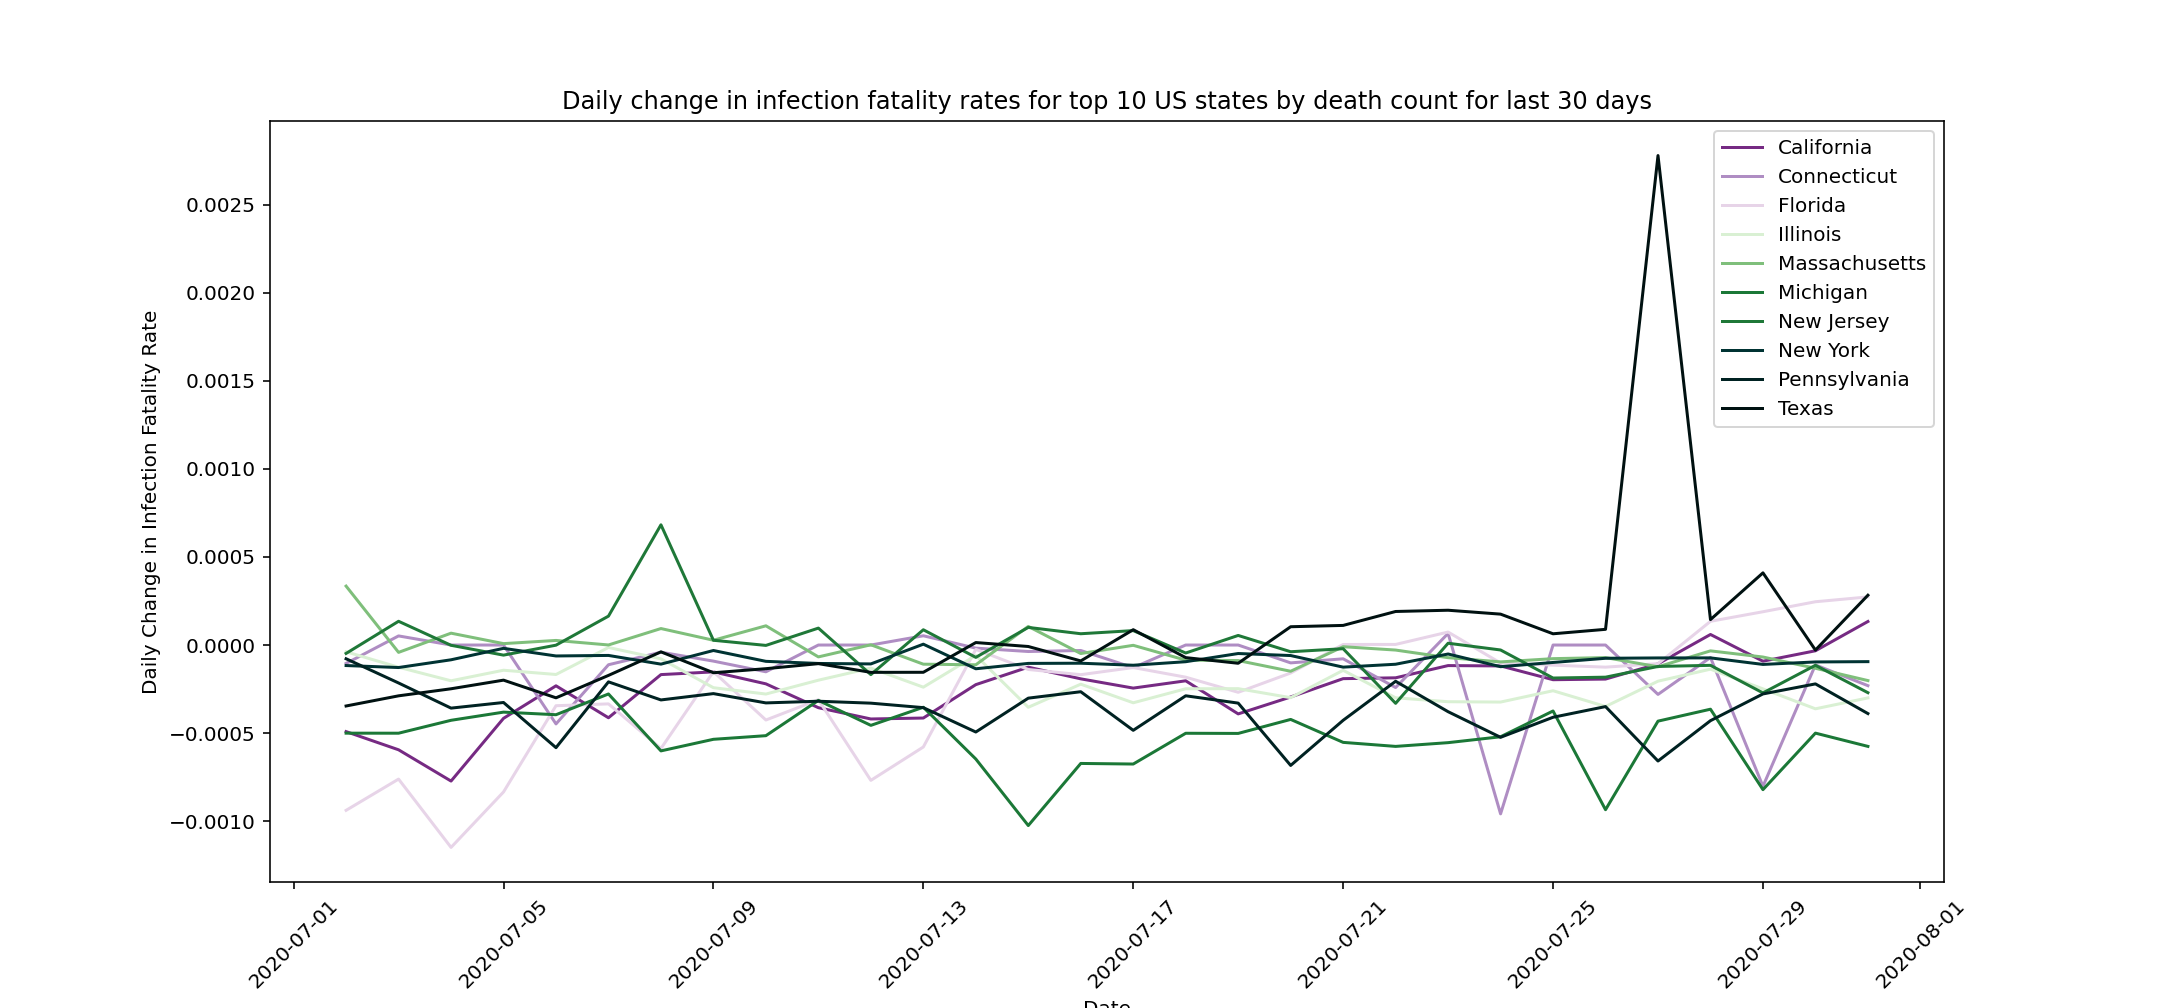

In [45]:
# plot the daily change in death rate
plotdeaths(data=d_top10_dr.diff(1), title="Daily change in infection fatality rates for top 10 US states by death count for last 30 days", ylabel="Daily Change in Infection Fatality Rate")

<IPython.core.display.Javascript object>


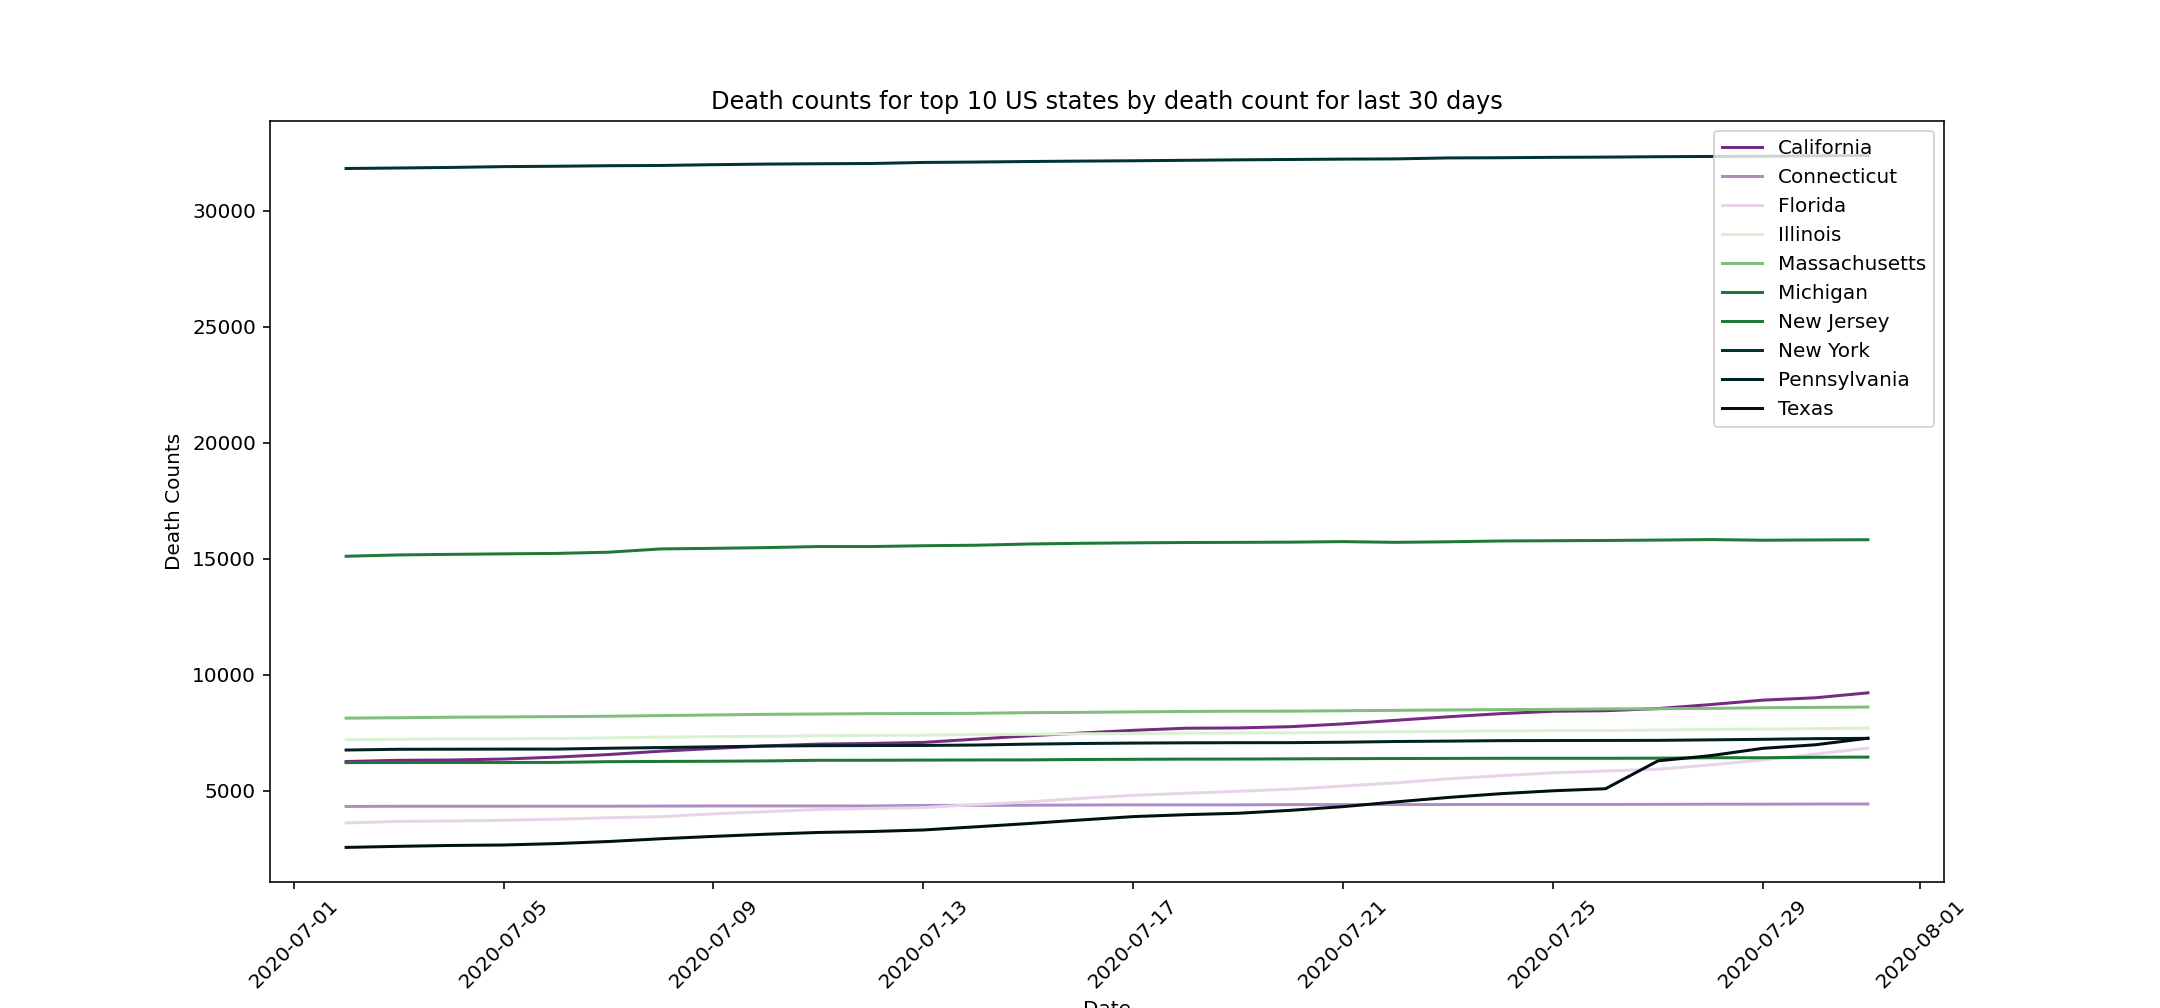

In [46]:
# plot death counts
plotdeaths(data=d_top10_deaths, title="Death counts for top 10 US states by death count for last 30 days", ylabel="Death Counts")

<IPython.core.display.Javascript object>


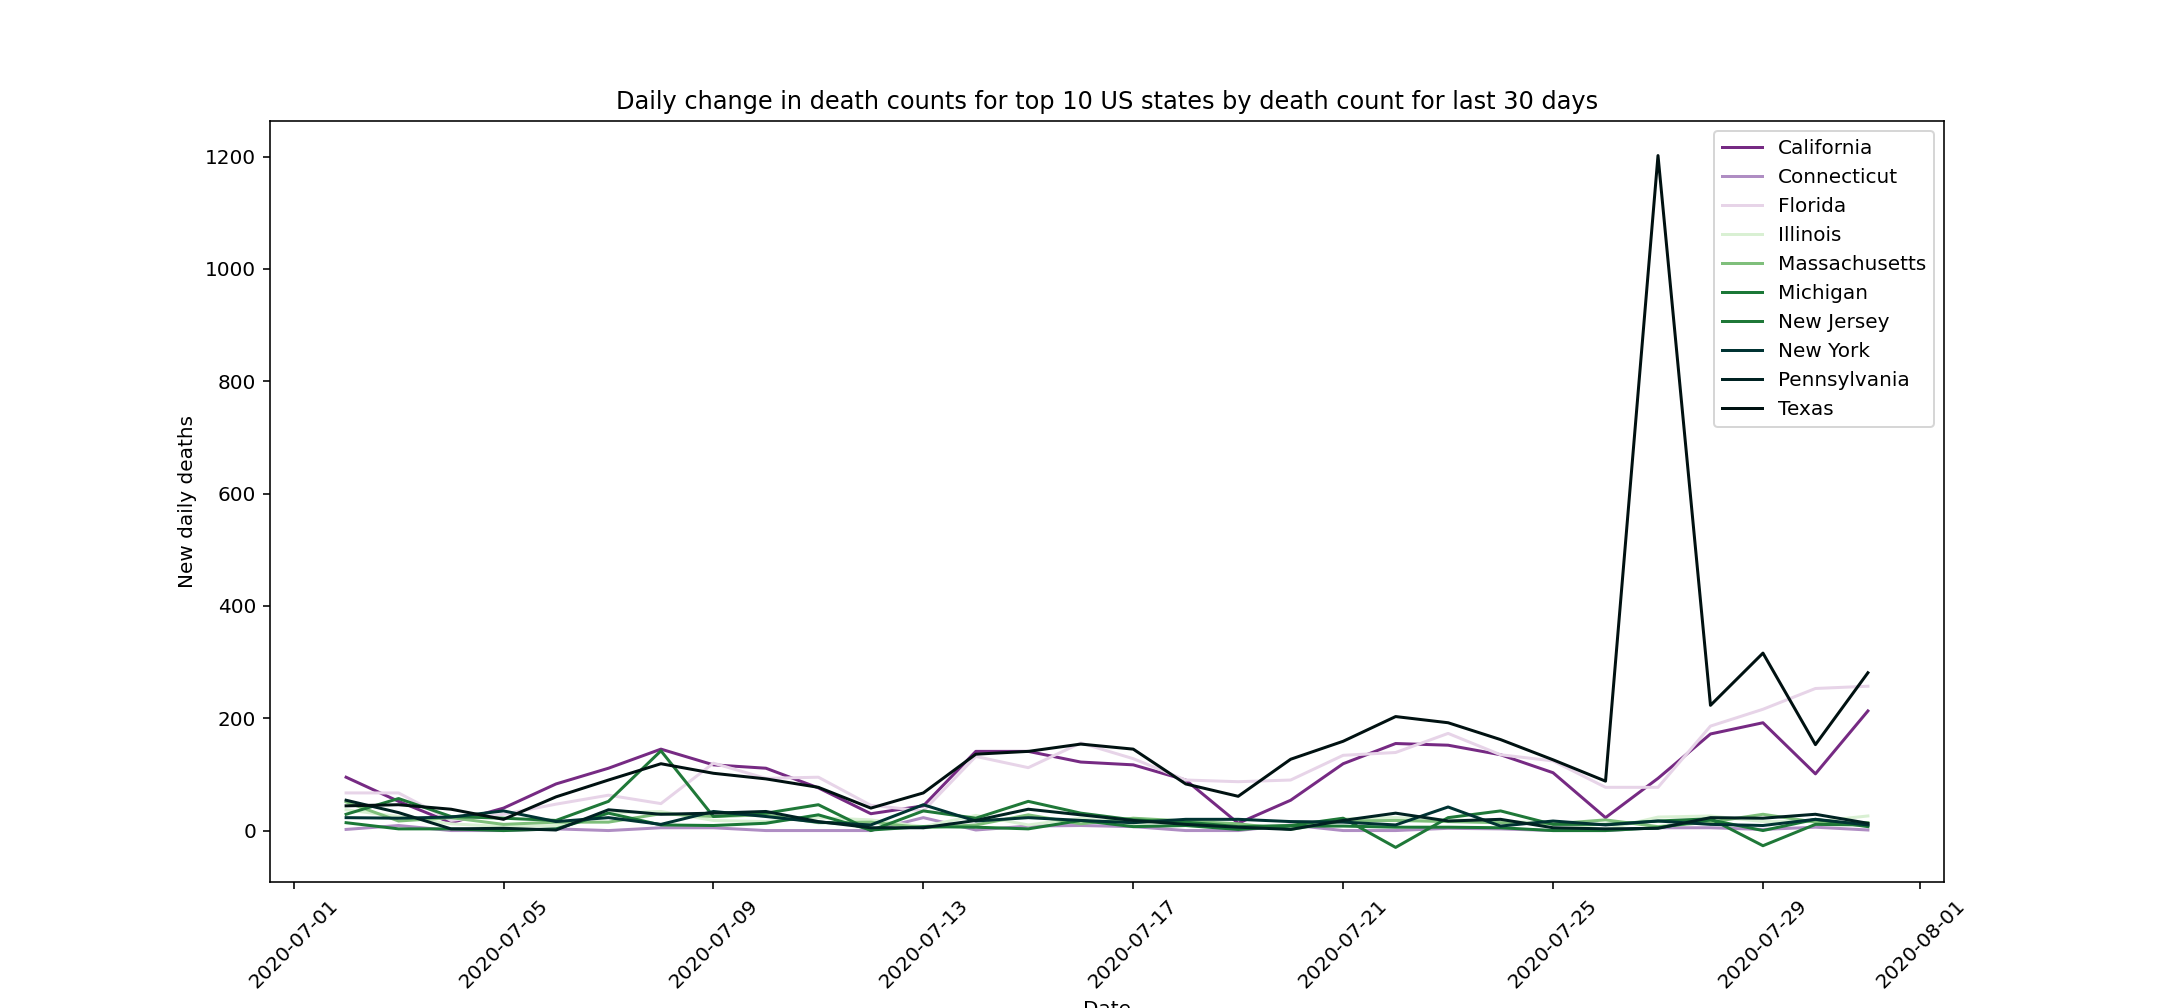

In [47]:
# plot daily change in death counts
plotdeaths(data=d_top10_deaths.diff(1), title="Daily change in death counts for top 10 US states by death count for last 30 days", ylabel="New daily deaths")

<IPython.core.display.Javascript object>


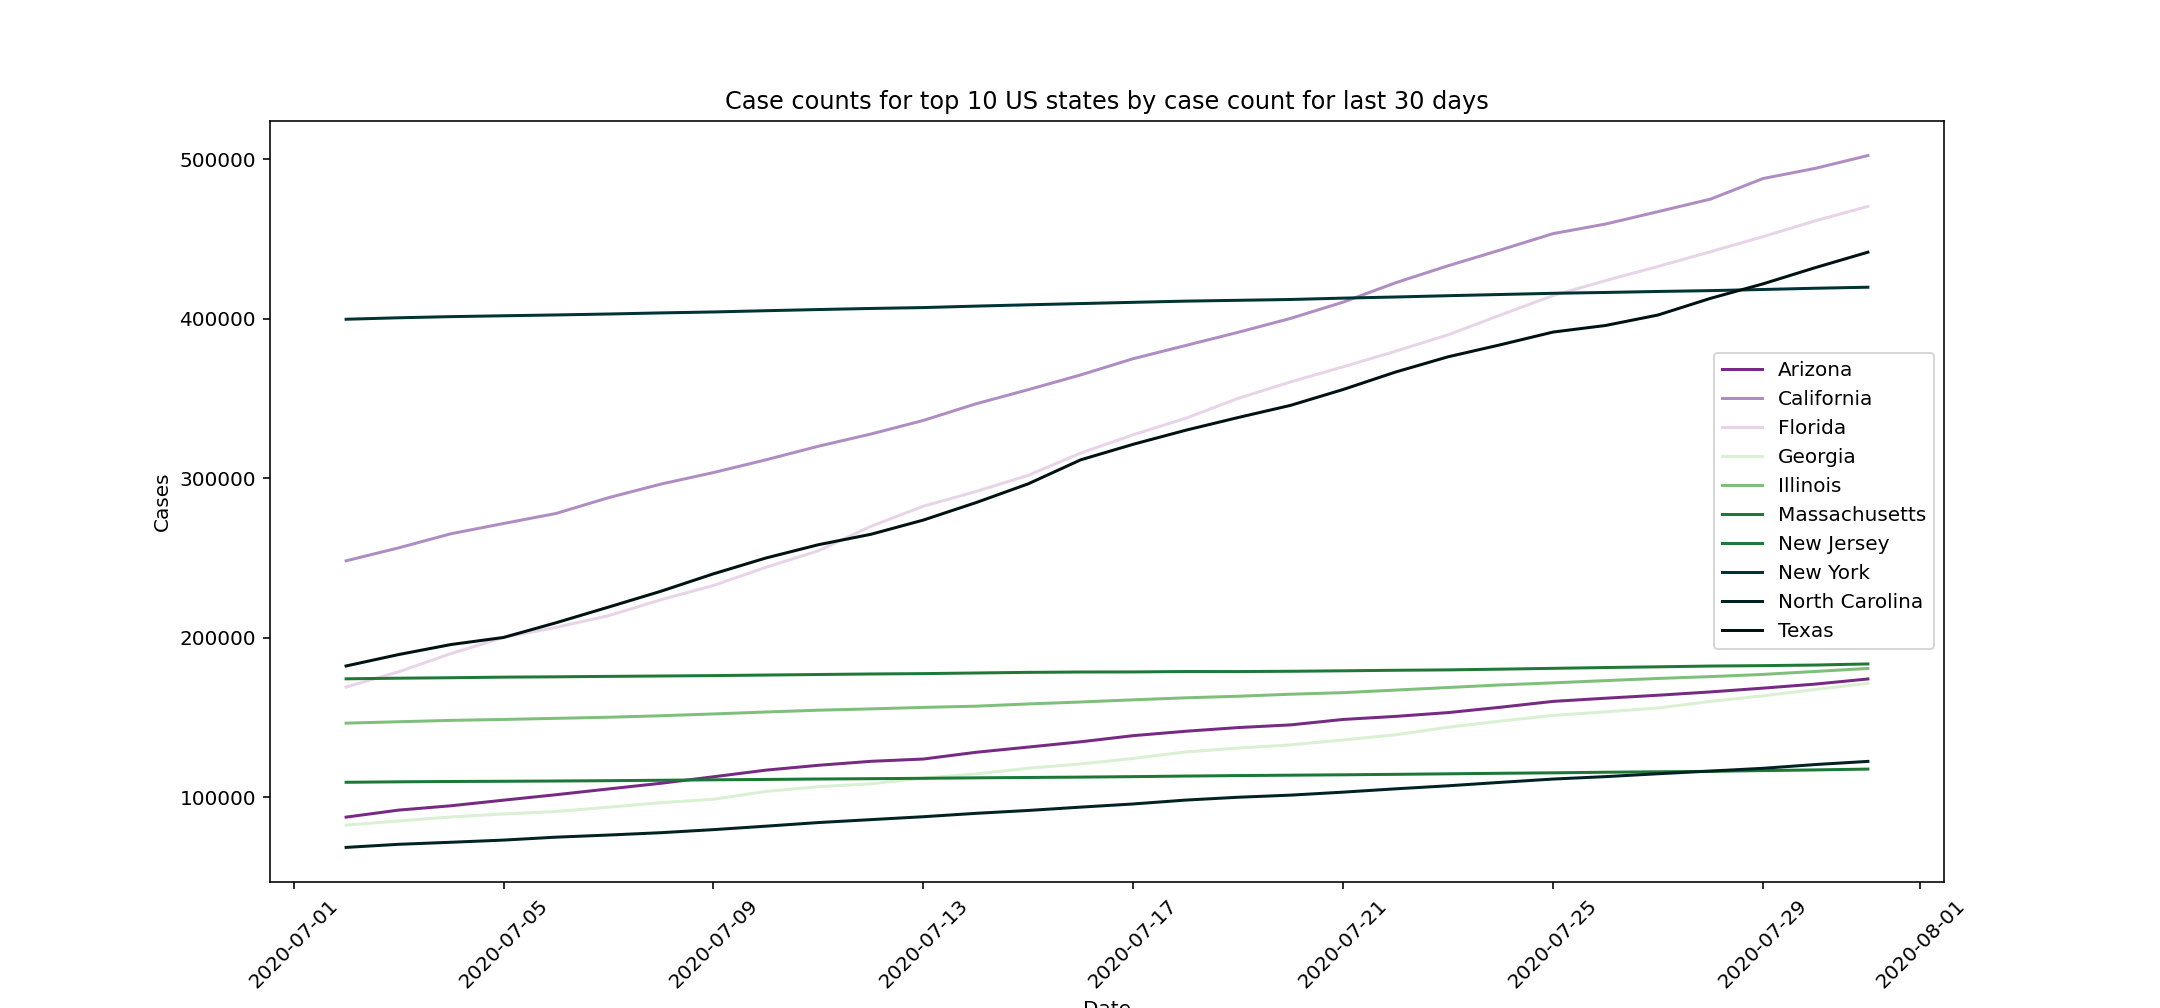

In [48]:
# plot case counts
plotdeaths(data=d_top10_cases, title="Case counts for top 10 US states by case count for last 30 days", ylabel="Cases")

<IPython.core.display.Javascript object>


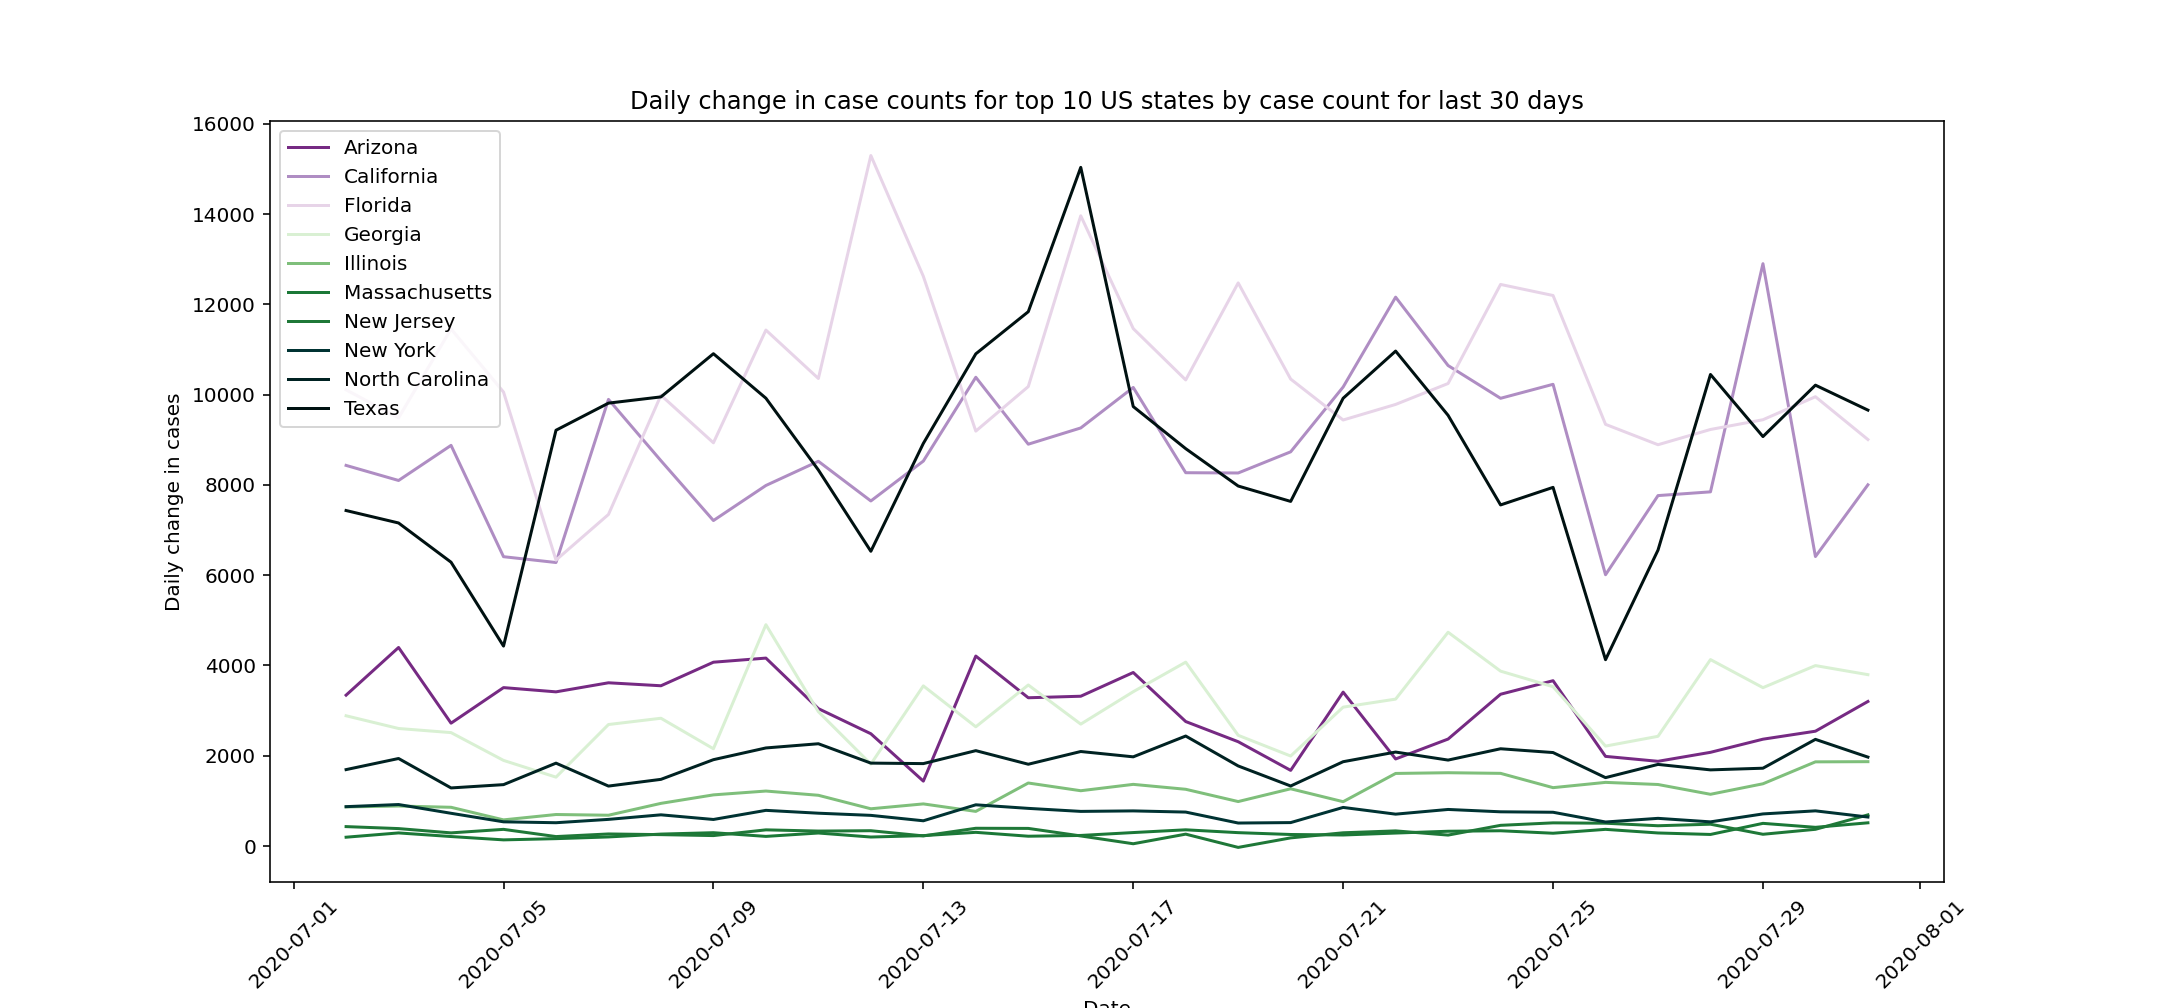

In [49]:
# plot daily change in case counts
plotdeaths(data=d_top10_cases.diff(1), title="Daily change in case counts for top 10 US states by case count for last 30 days", ylabel="Daily change in cases")

In [50]:
d_top10_cases.diff(1).tail(20)

state,Arizona,California,Florida,Georgia,Illinois,Massachusetts,New Jersey,New York,North Carolina,Texas
date_dt,,,,,,,,,,
2020-07-12,2488.0,7646.0,15300.0,1815.0,825.0,199.0,339.0,679.0,1837.0,6531.0
2020-07-13,1438.0,8530.0,12624.0,3548.0,933.0,230.0,224.0,559.0,1826.0,8921.0
2020-07-14,4209.0,10387.0,9194.0,2642.0,767.0,303.0,393.0,913.0,2113.0,10906.0
2020-07-15,3285.0,8904.0,10181.0,3568.0,1396.0,217.0,390.0,834.0,1812.0,11840.0
2020-07-16,3319.0,9264.0,13965.0,2701.0,1225.0,234.0,223.0,767.0,2094.0,15038.0
2020-07-17,3845.0,10161.0,11466.0,3419.0,1366.0,298.0,50.0,778.0,1976.0,9738.0
2020-07-18,2758.0,8272.0,10328.0,4074.0,1257.0,359.0,263.0,752.0,2437.0,8805.0
2020-07-19,2311.0,8266.0,12478.0,2453.0,985.0,296.0,-31.0,509.0,1774.0,7977.0
2020-07-20,1676.0,8735.0,10347.0,1994.0,1268.0,255.0,180.0,519.0,1330.0,7636.0


In [51]:
## Plot death rate for top 10 counties

palette_7 = ['#762a83','#af8dc3','#e7d4e8','#d9f0d3','#7fbf7b','#1b7837', '#1f7838', '#003333', '#002222', '#001111']

def plotdeaths(data, title, ylabel, days):
    ''' Plot deaths and death rates for the top 10 US counties'''
    # Create y as values and x as the index
    y0 = data[data.columns[0]][days:]
    y1 = data[data.columns[1]][days:]
    y2 = data[data.columns[2]][days:]
    y3 = data[data.columns[3]][days:]
    y4 = data[data.columns[4]][days:]
    y5 = data[data.columns[5]][days:]
    y6 = data[data.columns[6]][days:]
    y7 = data[data.columns[7]][days:]
    y8 = data[data.columns[8]][days:]
    y9 = data[data.columns[9]][days:]

    x = data.index[days:]

    # Set figure size.
    fig, ax = plt.subplots(figsize=(15,7))

    # Create plot.
    ax.plot(x, y0, color=palette_7[0])
    ax.plot(x, y1, color=palette_7[1])
    ax.plot(x, y2, color=palette_7[2])
    ax.plot(x, y3, color=palette_7[3])
    ax.plot(x, y4, color=palette_7[4])
    ax.plot(x, y5, color=palette_7[5])
    ax.plot(x, y6, color=palette_7[6])
    ax.plot(x, y7, color=palette_7[7])
    ax.plot(x, y8, color=palette_7[8])
    ax.plot(x, y9, color=palette_7[9])

    # set ticklabels
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 1 == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(45)
        else:
            label.set_visible(False)

    # Set legend
    #ax.legend([data.columns[0], data.columns[1], data.columns[2], data.columns[3], data.columns[4],
    #          data.columns[5], data.columns[6], data.columns[7], data.columns[8], data.columns[9]])

    ax.legend([data.columns[0], data.columns[1], data.columns[2], data.columns[3], data.columns[4],
              data.columns[5], data.columns[6], data.columns[7], data.columns[8], data.columns[9]])

    
    #Set title.
    ax.set(title=title, xlabel="Date", ylabel=ylabel)

    # show plot.
    plt.show()

<IPython.core.display.Javascript object>


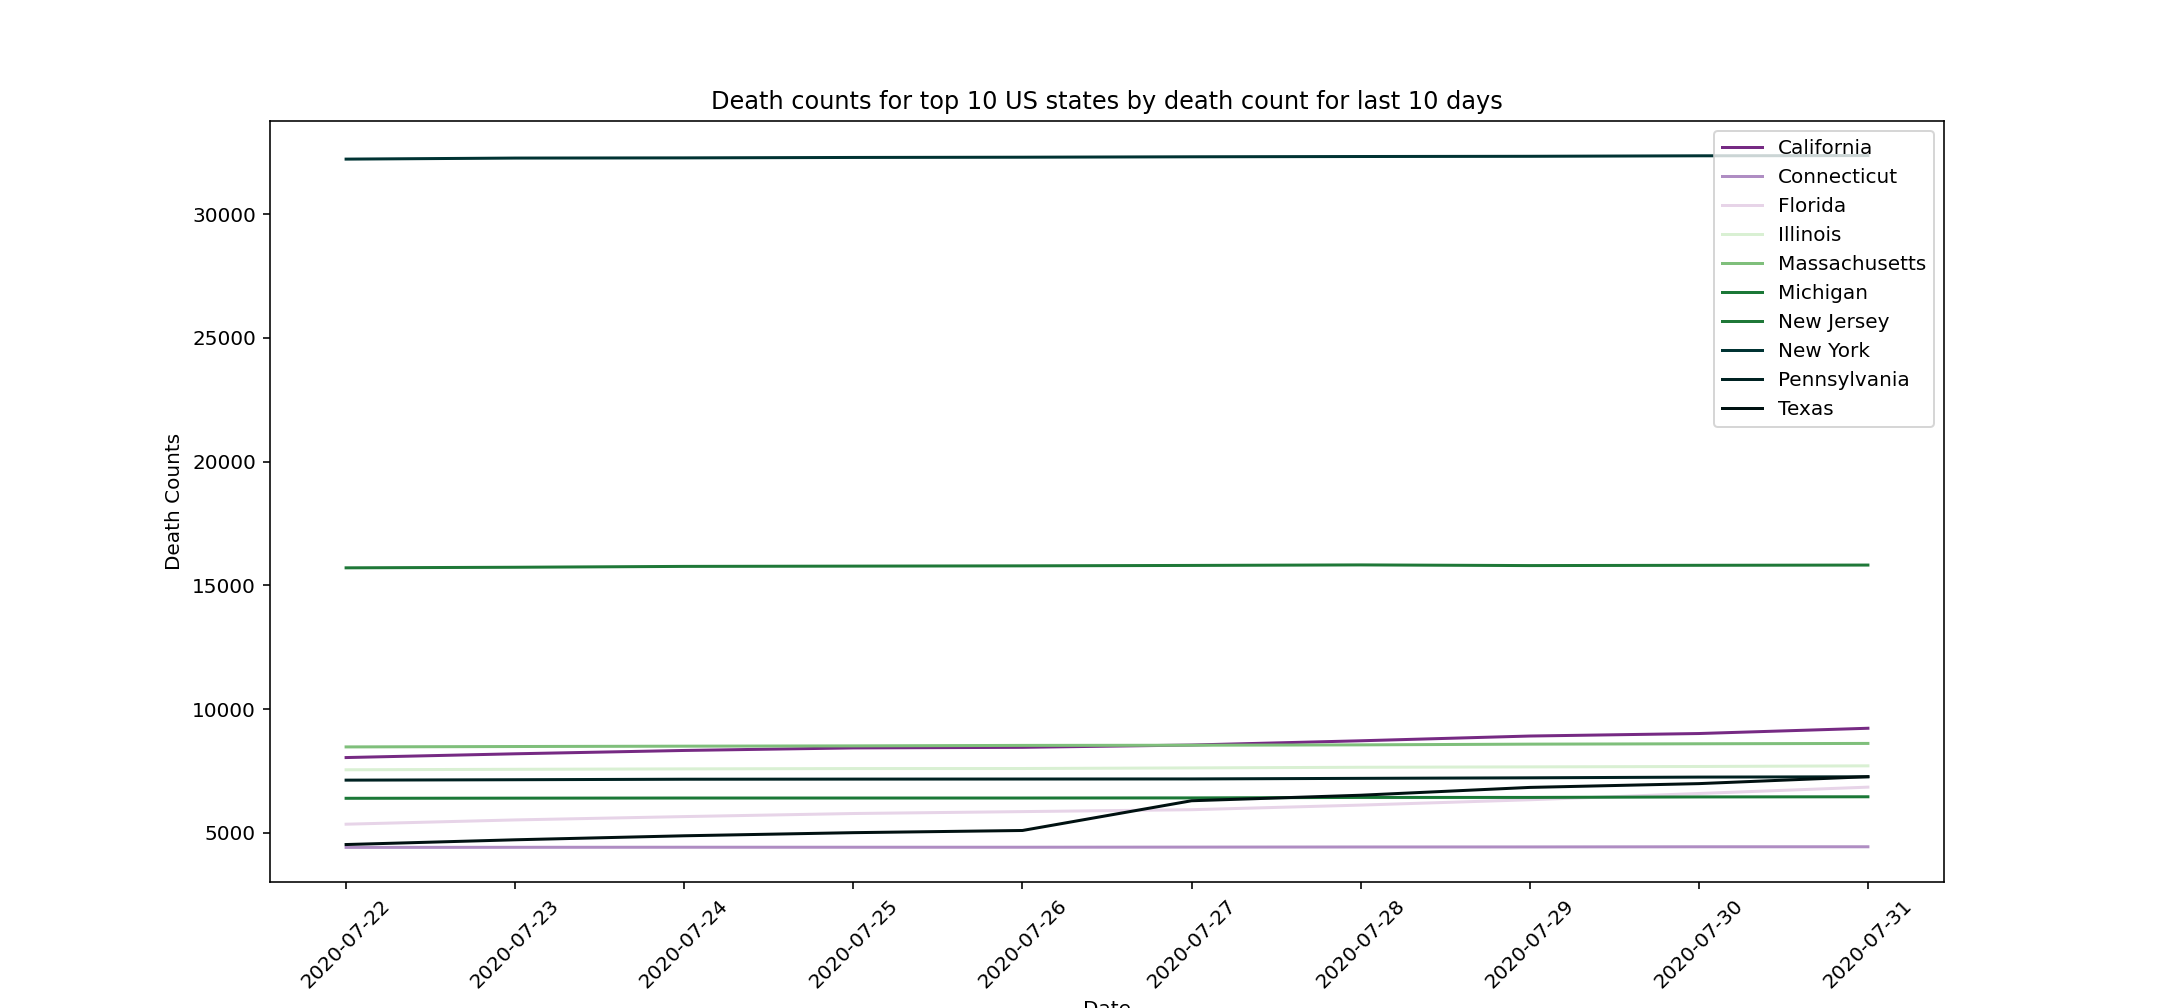

In [52]:
# plot death counts
plotdeaths(data=d_top10_deaths, title="Death counts for top 10 US states by death count for last 10 days", ylabel="Death Counts", days=-10)

<IPython.core.display.Javascript object>


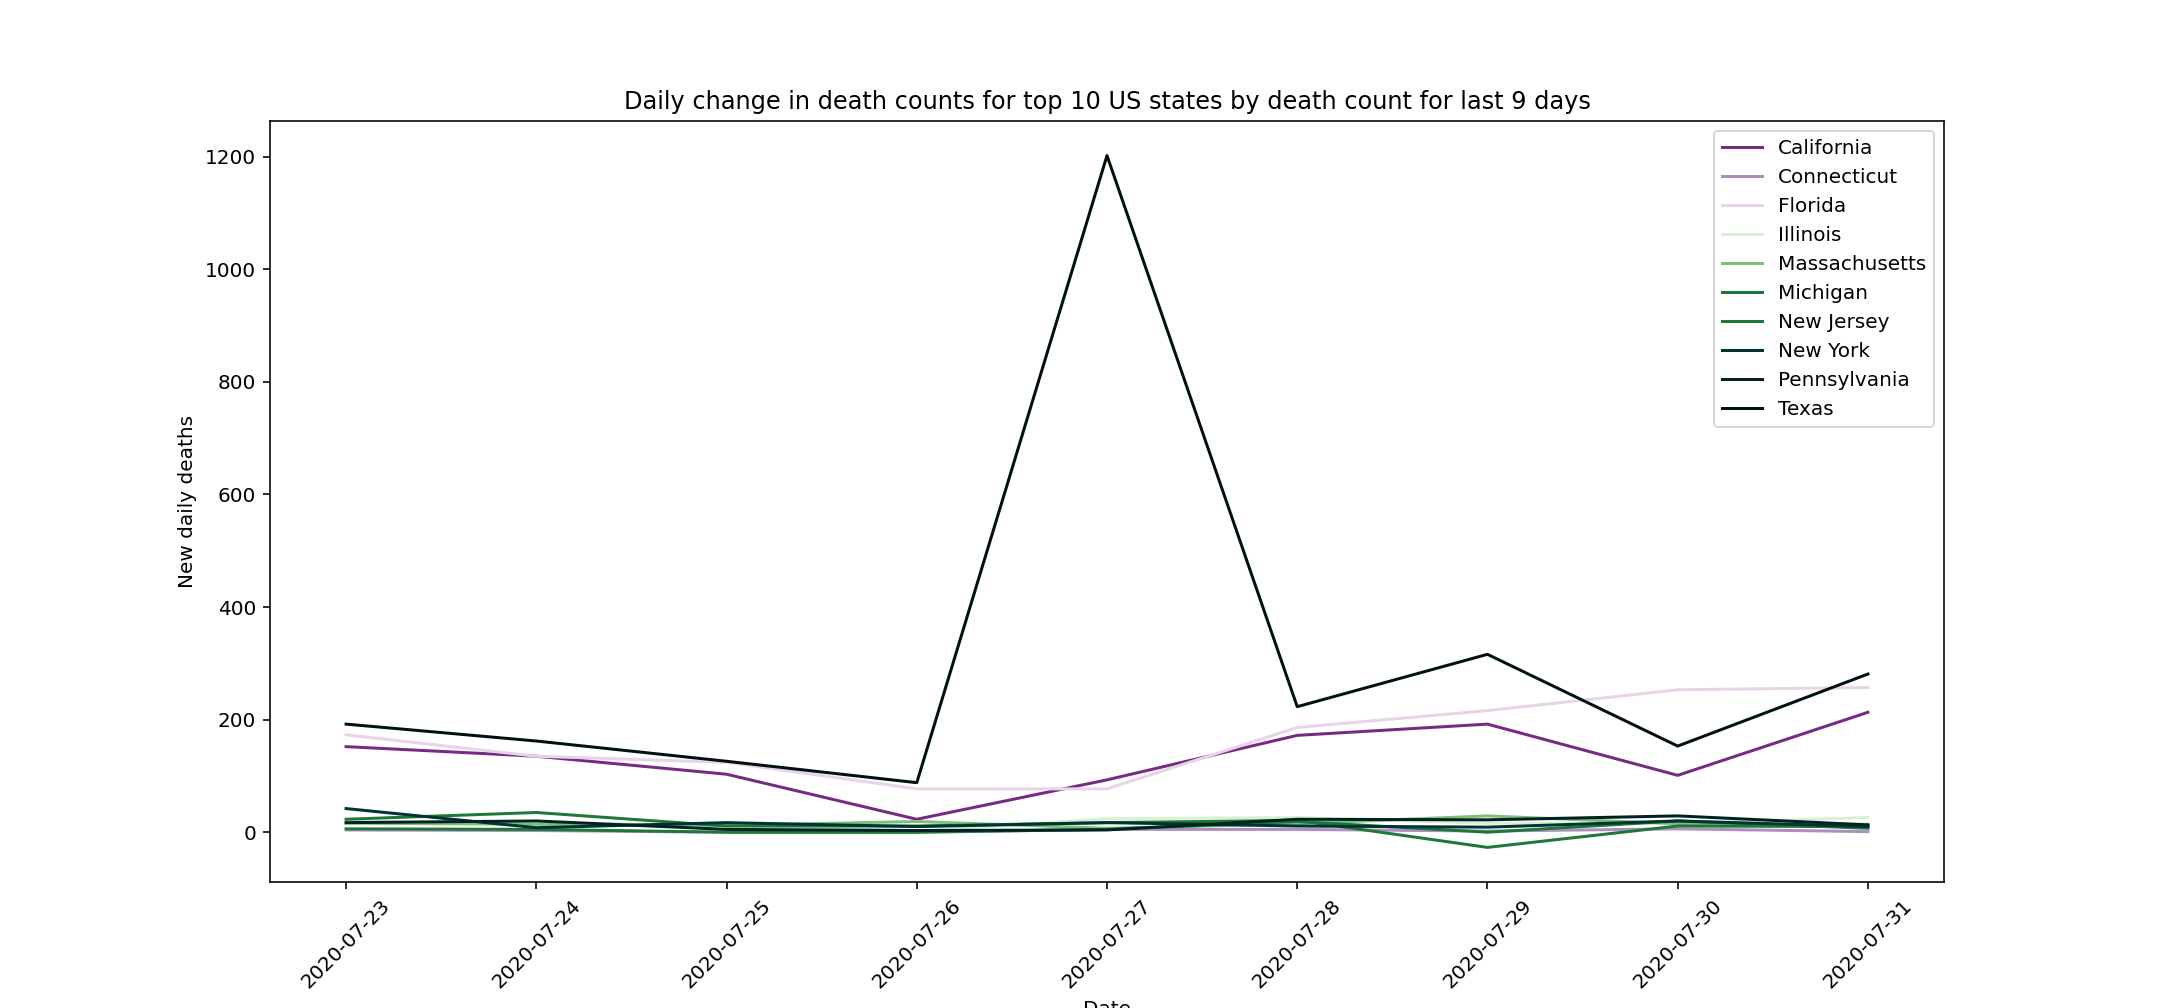

In [53]:
# plot daily change in death counts
plotdeaths(data=d_top10_deaths.diff(1), title="Daily change in death counts for top 10 US states by death count for last 9 days", ylabel="New daily deaths", days=-9)